<a href="https://colab.research.google.com/github/Stroded4ever/MQP/blob/main/Multivariate_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.3 MB/s eta 0:00:00


In [2]:
# ===================
# 0. Imports & Setup
# ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from arch import arch_model
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')
np.seterr(all='ignore')

sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded.")

Libraries loaded.


In [3]:
# ===================
# Config
# ===================
# ==========================================
# Exchange tickers (Yahoo Finance)
# ==========================================
# S&P 500 (US)              -> ^GSPC
# CAC 40 (Euronext Paris)   -> ^FCHI
# DAX (Euronext Germany)    -> ^GDAXI
# Shanghai Composite        -> 000001.SS
# Nikkei 225 (Japan)        -> ^N225
# FTSE 100 (UK)            -> ^FTSE
# NIFTY 50 (India)         -> ^NSEI
# Hang Seng (Hong Kong)    -> ^HSI
# ==========================================
TICKERS = ["9988.HK", "0388.HK"]   # Alibaba, HKEX
NEG_TICKERS = ["9988.HK", "0388.HK"]  # same pair for negative correlation (could choose others)
START_DATE = "2006-07-18"
END_DATE = "2025-10-21"

[*********************100%***********************]  2 of 2 completed



9988.HK GARCH(1,1) Results:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                9988.HK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3628.21
Distribution:                  Normal   AIC:                           7264.42
Method:            Maximum Likelihood   BIC:                           7285.54
                                        No. Observations:                 1450
Date:                Mon, Jan 05 2026   Df Residuals:                     1449
Time:                        23:18:08   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0699  7.284e-02

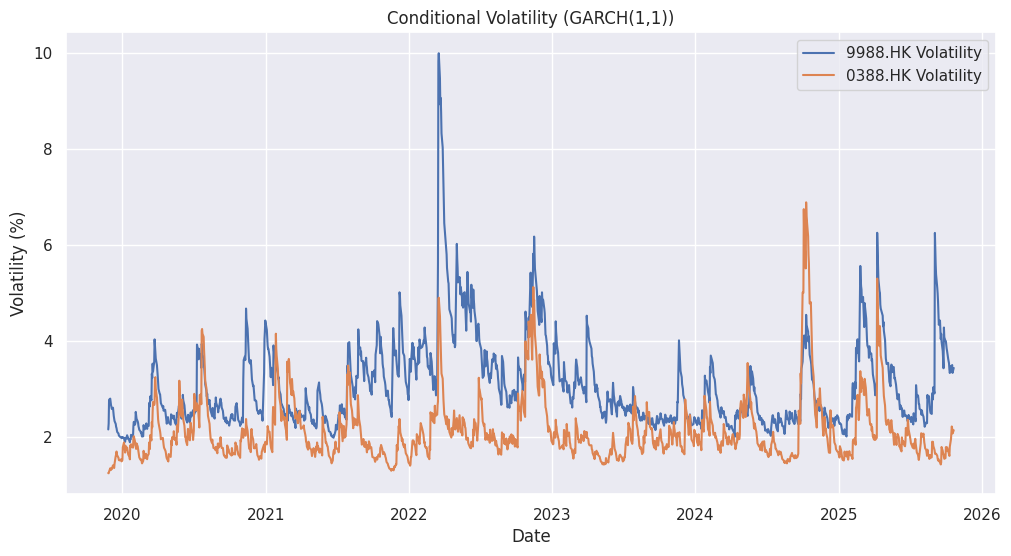

In [4]:
# Download data
df = yf.download(TICKERS, start=START_DATE, end=END_DATE)

# Robust adjusted or close selection
if isinstance(df.columns, pd.MultiIndex):
    if 'Adj Close' in df.columns.levels[0]:
        df_close = df['Adj Close']
    elif 'Close' in df.columns.levels[0]:
        df_close = df['Close']
    else:
        raise KeyError(f"No 'Adj Close' or 'Close' found. Columns: {df.columns.levels[0].tolist()}")
else:
    poss = [c for c in ['Adj Close','Close'] if c in df.columns]
    if not poss:
        raise KeyError(f"No 'Adj Close' or 'Close' in columns: {list(df.columns)}")
    df_close = df[poss[0]]

if isinstance(df_close, pd.Series):
    df_close = df_close.to_frame()

# Compute returns (percentage)
returns = df_close.pct_change().dropna()

# Fit GARCH(1,1)
garch_results = {}
for t in TICKERS:
    model = arch_model(returns[t] * 100, vol='GARCH', p=1, q=1)
    res = model.fit(disp='off')
    garch_results[t] = res
    print(f"\n{t} GARCH(1,1) Results:")
    print(res.summary())

# Plot conditional volatility
plt.figure()
for t in TICKERS:
    plt.plot(garch_results[t].conditional_volatility, label=f"{t} Volatility")
plt.title("Conditional Volatility (GARCH(1,1))")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.show()

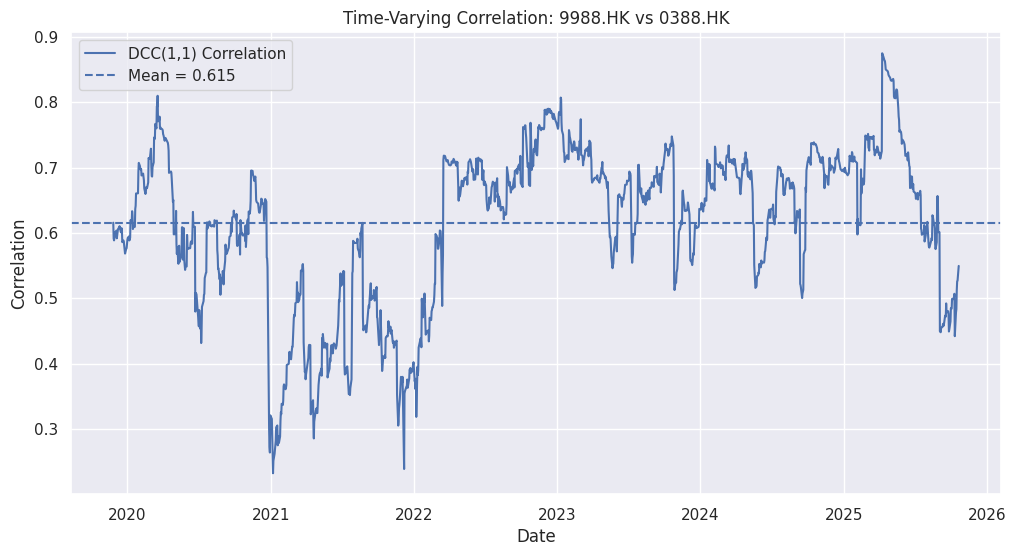

Estimated DCC params: a = 0.0309, b = 0.9554, persistence = 0.9863


In [5]:
#task 2
def build_standardized_residuals(results_dict, returns_df, tickers):
    zs = {}
    for tk in tickers:
        # Note: arch_model was fitted on returns*100
        mu = results_dict[tk].params['mu'] / 100
        sigma = results_dict[tk].conditional_volatility / 100
        r = returns_df[tk].loc[sigma.index]
        eps = r - mu
        z = eps / sigma
        zs[tk] = z.rename(tk)
    zdf = pd.concat(zs.values(), axis=1)
    return zdf.dropna()

def dcc_neg_loglik(params, z_array):
    a, b = params
    T, N = z_array.shape
    if (a < 0) or (b < 0) or (a + b >= 0.9999):
        return 1e12
    S = np.cov(z_array.T, bias=True)
    Q = S.copy()
    neg_ll = 0.0
    eps = 1e-12
    for t in range(T):
        zt = z_array[t,:][:, None]
        diag_q = np.sqrt(np.diag(Q) + eps)
        inv_diag_q = 1.0 / diag_q
        D = np.diag(inv_diag_q)
        R = D @ Q @ D
        if np.linalg.det(R) <= 0 or not np.all(np.isfinite(R)):
            return 1e12
        invR = np.linalg.inv(R)
        ll_t = 0.5 * (np.log(np.linalg.det(R) + eps) + float(zt.T @ invR @ zt))
        neg_ll += ll_t
        Q = (1 - a - b) * S + a * (zt @ zt.T) + b * Q
    return float(neg_ll)

def fit_dcc(z_df, verbose=False):
    z_arr = z_df.values
    x0 = np.array([0.02, 0.95])
    bounds = ((1e-8, 0.9999), (1e-8, 0.9999))
    cons = ({'type': 'ineq', 'fun': lambda x: 0.9999 - (x[0] + x[1])})
    res = minimize(lambda x: dcc_neg_loglik(x, z_arr), x0,
                   method='SLSQP', bounds=bounds, constraints=cons,
                   options={'maxiter':2000, 'ftol':1e-8})
    if verbose and not res.success:
        print("DCC warning:", res.message)
    a_hat, b_hat = res.x
    S = np.cov(z_arr.T, bias=True)
    Q = S.copy()
    corr_list = []
    for t in range(z_arr.shape[0]):
        zt = z_arr[t,:][:, None]
        diag_q = np.sqrt(np.diag(Q) + 1e-12)
        inv_diag_q = 1.0 / diag_q
        D = np.diag(inv_diag_q)
        R = D @ Q @ D
        corr_list.append(R[0,1])
        Q = (1 - a_hat - b_hat) * S + a_hat * (zt @ zt.T) + b_hat * Q
    return pd.Series(corr_list, index=z_df.index, name='DCC_Corr'), a_hat, b_hat

# Build standardized residuals
z_df = build_standardized_residuals(garch_results, returns, TICKERS)
dcc_corr, a_hat, b_hat = fit_dcc(z_df, verbose=True)

# Plot DCC correlation
plt.figure()
plt.plot(dcc_corr, label="DCC(1,1) Correlation")
plt.axhline(dcc_corr.mean(), linestyle='--', label=f"Mean = {dcc_corr.mean():.3f}")
plt.title(f"Time-Varying Correlation: {TICKERS[0]} vs {TICKERS[1]}")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.show()

print(f"Estimated DCC params: a = {a_hat:.4f}, b = {b_hat:.4f}, persistence = {a_hat + b_hat:.4f}")

[*********************100%***********************]  2 of 2 completed


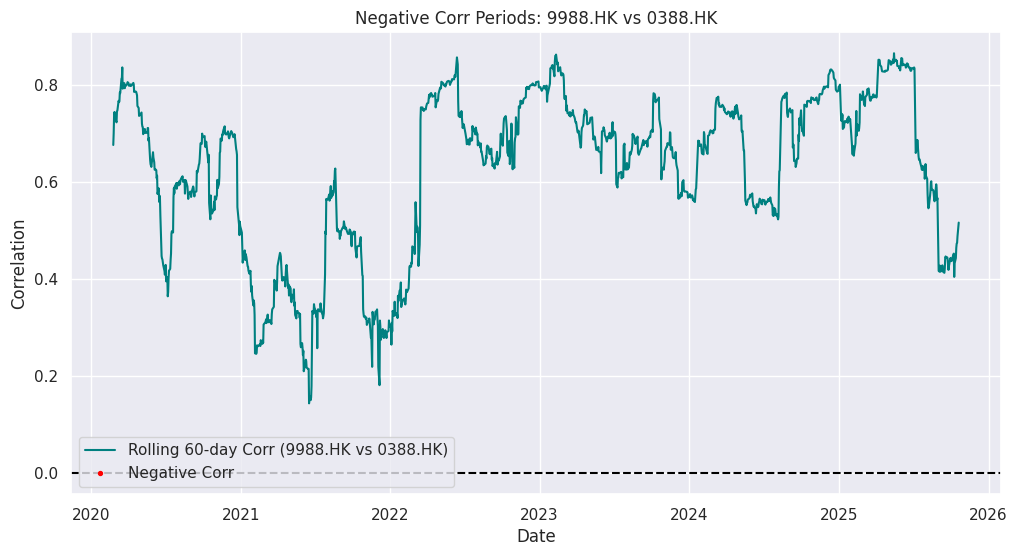

Average rolling corr: 0.6250117313016418
Min corr: 0.14406740173001079
Days negative: 0
Pct negative: 0.0 %


In [6]:
#task 3
# Download the same tickers (or choose a defensive one)
neg_df = yf.download(NEG_TICKERS, start=START_DATE, end=END_DATE)

# Robust close selection
if isinstance(neg_df.columns, pd.MultiIndex):
    if 'Adj Close' in neg_df.columns.levels[0]:
        neg_close = neg_df['Adj Close']
    elif 'Close' in neg_df.columns.levels[0]:
        neg_close = neg_df['Close']
    else:
        raise KeyError(f"No 'Adj Close' or 'Close'. Columns: {neg_df.columns.levels[0].tolist()}")
else:
    poss = [c for c in ['Adj Close','Close'] if c in neg_df.columns]
    if not poss:
        raise KeyError(f"No 'Adj Close' or 'Close'. Found: {list(neg_df.columns)}")
    neg_close = neg_df[poss[0]]

if isinstance(neg_close, pd.Series):
    neg_close = neg_close.to_frame()

neg_returns = neg_close.pct_change().dropna()

rolling_corr_neg = neg_returns[NEG_TICKERS[0]].rolling(60).corr(neg_returns[NEG_TICKERS[1]])
neg_periods = rolling_corr_neg[rolling_corr_neg < 0]

plt.figure()
plt.plot(rolling_corr_neg, label=f"Rolling 60-day Corr ({NEG_TICKERS[0]} vs {NEG_TICKERS[1]})", color='teal')
plt.axhline(0, color='black', linestyle='--')
plt.scatter(neg_periods.index, neg_periods.values, color='red', label='Negative Corr', s=8)
plt.title(f"Negative Corr Periods: {NEG_TICKERS[0]} vs {NEG_TICKERS[1]}")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.show()

print("Average rolling corr:", rolling_corr_neg.mean())
print("Min corr:", rolling_corr_neg.min())
print("Days negative:", len(neg_periods))
print("Pct negative:", 100 * len(neg_periods) / len(rolling_corr_neg), "%")